In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN
import networkx as nx


from tqdm import tqdm
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve

In [3]:
torch.cuda.device_count()

4

In [4]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [5]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [6]:
showers_train_10_F = torch.load('./EM_data/showers_train_10_all.pt')

In [7]:
showers_train = [shower.to(device) for shower in showers_train_10_F[:]]

In [8]:
len(showers_train)

230

## Features creation

In [9]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/(data[:, 0]+0.00001)).view(shape_0, 1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_2 = (data[:, 0]/(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_3 = (data[:, 1]/(data[:, 2]+0.00001)).view(shape_0,1)
    
    feat_4 = (torch.sin(feat_0) + torch.cos(feat_0))/(feat_0+0.00001)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3, feat_4), 1)

In [10]:
showers_train[1].x[0]

tensor([ 0.1140, -0.9186, -1.5420, -0.0532, -0.0118, -1.4473, -0.6003, -0.0739,
         0.5957,  0.6006], device='cuda:0')

In [11]:
showers_train[0].x[0]

tensor([-1.0178, -0.8698, -2.4331, -0.1505,  0.1620,  0.7071, -0.5502,  0.4183,
         0.3575,  1.9937], device='cuda:0')

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [12]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [13]:
Z_centered = Z - 73701. / 2

In [14]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [15]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

In [16]:
Z_0

array([-24330.68990707, -23056.30922318, -21785.49051285, ...,
        34226.60112381,  34224.50065613,  34225.58069229])

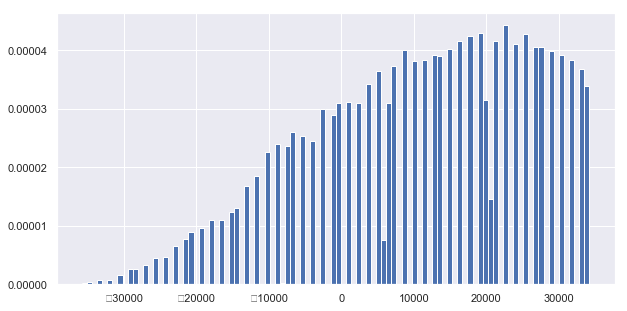

In [17]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


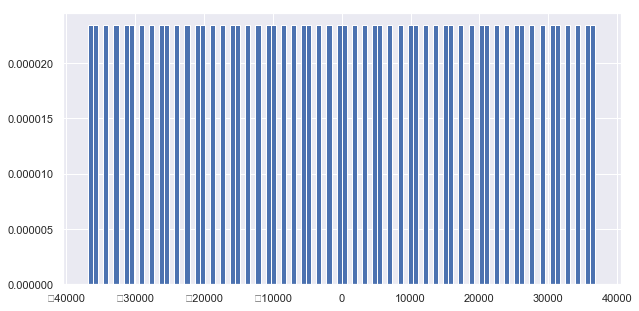

In [18]:
plt.figure(figsize=(10, 5))

# the histogram of the data
plt.hist(Z_centered, 100, density=True)

plt.grid(True)
plt.show()

## Masks for activating only those edges that are connecting the same shower

In [19]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu()) * np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            if z_0_i == z_i:
                # TODO data.edge_index[0] vs data.edge_index[1]
                orders[i][(data.edge_index[0] == j).cpu().numpy().astype(bool)] = 1
            
    return orders.astype(np.uint8)

In [20]:
showers_train[0]

Data(edge_attr=[103760, 1], edge_index=[2, 103760], pos=[10628, 5], x=[10628, 10], y=[10628])

In [21]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

## GNN 

In [32]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels).to(device)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate(torch.index_select(edge_index[:, torch.ByteTensor(order).to(device)], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
            
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [42]:
n = showers_train[0].x.shape[1]

class GraphNN_KNN(torch.nn.Module):
    n = showers_train[0].x.shape[1]
    
    def __init__(self, k=n, dim_out=10):
        super().__init__()
        self.k = k
        
        self.emconv = EmulsionConv(self.k, self.k)    
      
        self.layer_2 = nn.Linear(self.k, 18)
        self.nonlinear_2 = nn.LeakyReLU()
        
        self.layer_3 = nn.Linear(18, 24)
        self.nonlinear_3 = nn.ReLU()

        
        self.output = nn.Linear(24, dim_out)
        
        
    def forward(self, data):
        x, edge_index, orders = data.x, data.edge_index, data.mask
        
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)  
        
        x = self.nonlinear_2(self.layer_2(x))
        
        x = self.nonlinear_3(self.layer_3(x))
        
        
        return self.output(x)


In [43]:
model = GraphNN_KNN(dim_out=288).to(device)

In [44]:
from torch_geometric.data import DataLoader   

In [45]:
for i in range(len(showers_train)):
    showers_train[i].mask = torch.tensor(masks[i], dtype=torch.uint8)

In [46]:
train, test = train_test_split(showers_train)

In [47]:
train_loader = DataLoader(train, batch_size=1, shuffle=False)

#valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    #sampler=valid_sampler, num_workers=num_workers)

test_loader = DataLoader(test, batch_size=1, shuffle=False)

----------------

In [48]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(288*2, 144),
                                nn.Tanh(),
                                nn.Linear(144, 144),
                                nn.Tanh(),
                                nn.Linear(144, 32),
                                nn.Tanh(),
                                nn.Linear(32, 1),
                                nn.Sigmoid()).to(device)

In [49]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(model.parameters()) + list(edge_classifier.parameters()), lr=learning_rate)

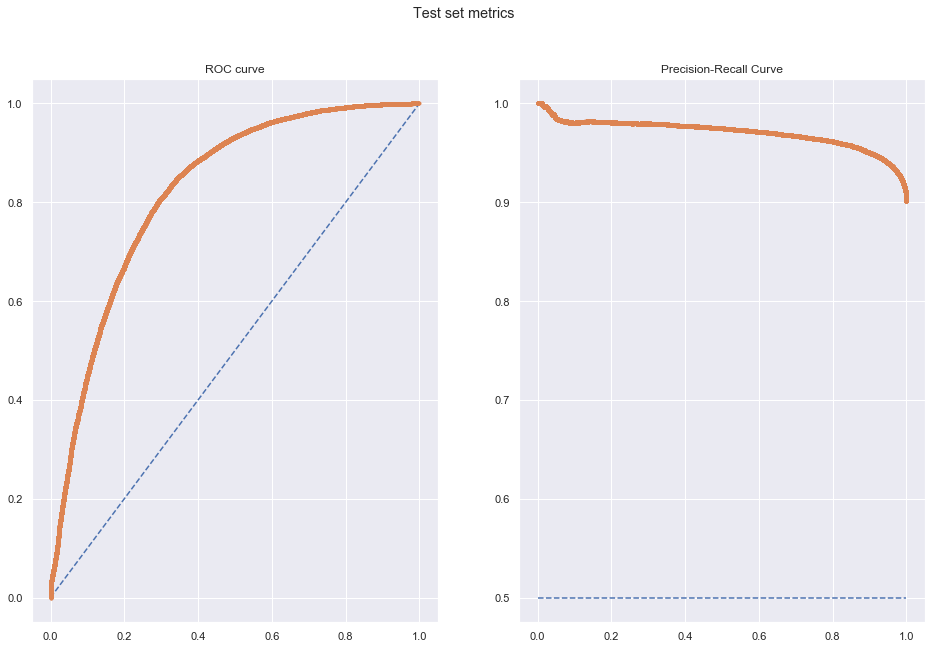

#864, Test loss: 0.2413008
mean AUC per batch: 0.852


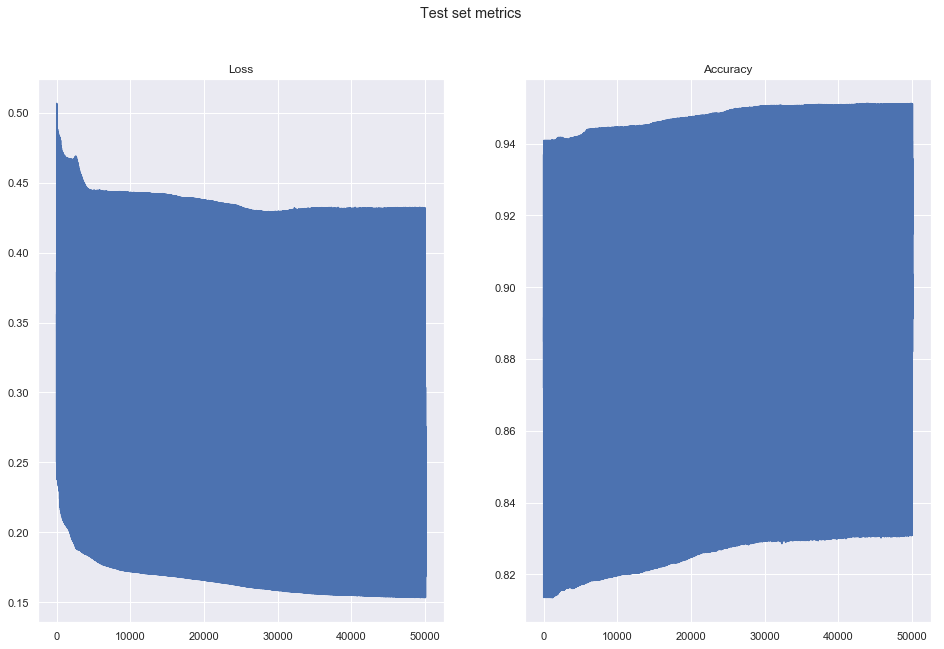

In [ ]:
n_epoch = 1000

train_losses = []

test_losses = []

accs = []

aucs = []
    
for i in range(1, n_epoch + 1):
      
    for shower in train_loader:

        embeddings = model(shower)


        edge_labels = (shower.y[shower.edge_index[0]] 
                       == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                               embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data)

        
        # calculate the batch loss
        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.detach().cpu().numpy())

    

    for shower in test_loader:
        
        embeddings = model(shower)


        edge_labels = (shower.y[shower.edge_index[0]] 
                           == shower.y[shower.edge_index[1]])  



        edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                                   embeddings[shower.edge_index[1]]], dim=1)


        edge_predicted = edge_classifier(edge_data)


        # calculate the batch loss
        loss = criterion(edge_predicted.view(-1), edge_labels.view(-1).float())
        loss.backward()
        test_losses.append(loss.detach().cpu().numpy())

        y_true = edge_labels.view(-1).float().cpu().detach().numpy()
        y_pred = edge_predicted.view(-1).cpu().detach().numpy()


        acc = accuracy_score(y_true, y_pred.round())

        accs.append(acc)

        auc = roc_auc_score(y_true, y_pred)
        
        aucs.append(auc)

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

        clear_output()
        
        fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,10))

        ax = axs[0]
        ax.plot([0, 1], [0, 1], linestyle='--')
        # plot the roc curve for the model
        ax.plot(fpr, tpr, marker='.')
        ax.set_title('ROC curve')

        ax = axs[1]
        ax.plot([0, 1], [0.5, 0.5], linestyle='--')
        ax.plot(recall, precision, marker='.')
        ax.set_title('Precision-Recall Curve')


        fig.suptitle('Test set metrics')

        plt.show()

    
    
    
    print("#%i, Test loss: %.7f"%(i+1,np.mean(test_losses)),flush=True)
    print('mean AUC per batch: %.3f' % np.mean(aucs))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(16,10))
    
    ax = axs[0]
    ax.plot(test_losses)
    ax.set_title('Loss')

    ax = axs[1]
    ax.plot(accs)
    ax.set_title('Accuracy')
    
    #ax = axs[1][0]
    #ax.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    #ax.plot(fpr, tpr, marker='.')
    #ax.set_title('ROC curve')

    #ax = axs[1][1]
    #ax.plot([0, 1], [0.5, 0.5], linestyle='--')
    #ax.plot(recall, precision, marker='.')
    #ax.set_title('Precision-Recall Curve')


    fig.suptitle('Test set metrics')

    plt.show()





In [ ]:
import pickle

In [ ]:
filename = 'finalized_model_all.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
filename = 'finalized_edge_classifier_all.sav'
loaded_edge_classifier = pickle.load(open(filename, 'rb'))

In [ ]:
len(test_loader)

In [ ]:
i = 0

for shower in test_loader:
    
    clear_output()
    
    print(i)
        
    embeddings = loaded_model(shower)

    edge_labels = (shower.y[shower.edge_index[0]] 
                           == shower.y[shower.edge_index[1]])  

    edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                                   embeddings[shower.edge_index[1]]], dim=1)

    edge_predicted = loaded_edge_classifier(edge_data)
    
    i+=1
    

In [ ]:
len(edge_predicted)

In [ ]:
SHOWER = showers_train[36]

In [ ]:
SHOWER

In [ ]:
SHOWER.weight = torch.tensor(edge_predicted, dtype=torch.float32)

In [ ]:
SHOWER.is_directed()

In [130]:
len(np.unique(SHOWER.y.cpu().detach().numpy()))

24

*Clear the edges with predicted weight < 0.45*

In [ ]:
edge_indices = SHOWER.edge_index.t()[(edge_predicted > 0.45).view(-1)]

In [ ]:
len(edge_indices)

*Collect weights*

In [ ]:
weights = SHOWER.weight[(edge_predicted > 0.45).view(-1)].cpu().detach().numpy()

In [ ]:
len(weights)

*Clear single points*

In [ ]:
points = np.unique(edge_indices.view(-1).cpu().detach().numpy())

In [ ]:
points.sort()

In [ ]:
points[-10:]

In [ ]:
len(points)

*Check the direction of th graph*

In [ ]:
SX = SHOWER.pos.t()[0].cpu().detach().numpy()
SY = SHOWER.pos.t()[1].cpu().detach().numpy()
SZ = SHOWER.pos.t()[2].cpu().detach().numpy()
TX = SHOWER.pos.t()[3].cpu().detach().numpy()
TY = SHOWER.pos.t()[4].cpu().detach().numpy()

*Directed Graph Creating*

In [ ]:
G = nx.DiGraph()

In [ ]:
#add nodes to graph
nodes_to_add = []

In [ ]:
for k in points:
    node_id = k
    nodes_to_add.append(
            (
                node_id,
                {  
                    'features': {
                    
                        'SX': SX[k]*5000,
                        'SY': SY[k]*5000,
                        'SZ': SZ[k]*5000,
                        'TX': TX[k],
                        'TY': TY[k],
                    },
                }
            )
        )
   

In [ ]:
len(nodes_to_add)

In [ ]:
G.add_nodes_from(nodes_to_add)

In [ ]:
#add edges to graph 
edges_to_add = []
    
for k in range(len(edge_indices)):
    p0 = edge_indices.cpu().detach().numpy()[k][0]
    p1 = edge_indices.cpu().detach().numpy()[k][1]
    weight = 1.0-float(weights[k])
    edges_to_add.append((p0, p1, weight))



In [ ]:
G.add_weighted_edges_from(edges_to_add)

In [ ]:
from functools import total_ordering

@total_ordering
class ClusterHDBSCAN(object):
    def __init__(self, weight: float, cl_size: int, clusters: list = None, nodes: list = None):
        # init
        self.nodes = set()
        self.nodes_in = Counter()
        self.nodes_out = Counter()
        
        self.weights_nodes_dict = defaultdict(set)
        
        self.weight_death = weight
        self.lambda_death = 1. / (weight + 1e-5)
        
        self.weight_birth = weight
        self.lambda_birth = 1. / (weight + 1e-5)
        
        
        self.children = []
        self.falling_out_points = []
        
        assert clusters is not None or nodes is not None
        if clusters is not None:
            for cluster in clusters:
                self.nodes.update(cluster.nodes)
                self.nodes_in.update(cluster.nodes_in)
                self.nodes_out.update(cluster.nodes_out)
                self.weights_nodes_dict[weight].update(cluster.nodes)
                if cluster.is_cluster:
                    cluster.set_weight_birth(weight)
                    self.children.append(cluster)
                else:
                    self.falling_out_points.append(cluster)
        else:
            self.nodes.update(nodes)
            self.nodes_out.update(nodes)
            self.weights_nodes_dict[weight].update(nodes)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.cl_size = cl_size
        self.is_cluster = len(self) >= cl_size
        self.is_noise = not self.is_cluster
        self.stability = None
        
        
    def append(self, weight: float, clusters: list):
        """
        Adding
        """
        for cluster in clusters:
            self.nodes.update(cluster.nodes)
            self.weights_nodes_dict[weight].update(cluster.nodes)
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        self.frozennodes = frozenset(self.nodes)
        self.__hash = hash(self.frozennodes)
        self.listnodes = list(self.nodes)
        self.npnodes = np.array(list(self.nodes)).astype(np.int32)
        self.is_cluster = len(self) >= self.cl_size
        self.is_noise = not self.is_cluster
        return self
    
    def __iter__(self):
        for child in self.children:
            yield child
    
    def __contains__(self, node):
        return node in self.nodes
    
    def __len__(self):
        return len(self.nodes)
    
    def __hash__(self):
        return self.__hash
    
    def __eq__(self, other):
        return self.__hash == other.__hash

    def __lt__(self, other):
        return self.__hash < other.__hash
    
    def set_weight_birth(self, weight: float):
        self.weight_birth = weight
        self.lambda_birth = 1 / (weight + 1e-5)
        
    def calculate_stability(self):
        self.stability = 0.
        self.lambda_birth = 1 / (max(self.weights_nodes_dict.keys()) + 1e-5)
        norm = self.lambda_birth
        for weight in self.weights_nodes_dict:
            self.stability += len(self.weights_nodes_dict[weight]) * (1 / (weight + 1e-5) - self.lambda_birth) * norm
            
def calc_stabilities(root):
    root.calculate_stability()
    for child in root:
        calc_stabilities(child)
        
        
def class_disbalance(cluster, graph):
    subgraph = graph.subgraph(cluster.nodes)
    signal = []
    for _, node in subgraph.nodes(data=True):
        signal.append(node['signal'])
    return list(zip(*np.unique(signal, return_counts=True)))

def flat_clusters(root):
    if root.is_cluster:
        yield root
        
    for child in root:
        for cluster in flat_clusters(child):
            yield cluster
            
def reed_stabilities(root, level=0):
    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)), end=' ')
    print('stability={:.2f}'.format(root.stability))
    for child in root:
        reed_stabilities(child, level + 1)

def print_class_disbalance_for_all_clusters(root, graph, level=0):
    class_disbalance_tuples = class_disbalance(root, graph)

    print('    ' * (level - 1) + '+---' * (level > 0), end='')
    print('len={}'.format(len(root)))
    print('    ' * (level), end='')
    print(class_disbalance_tuples, end=' ')
    print('stability={:.3f}'.format(root.stability))
    for child in root:
        print_class_disbalance_for_all_clusters(child, graph, level + 1)
        
def leaf_clusters(root):
    if root.is_cluster and len(root.children) == 0:
        yield root
        
    for child in root:
        for cluster in leaf_clusters(child):
            yield cluster

def max_level_clusters(root, level=0, max_level=2):
    if level == max_level and root.is_cluster:
        yield root
        
    for child in root:
        for cluster in max_level_clusters(child, level=level+1, max_level=max_level):
            yield cluster
            
            
def recalc_tree(root):
    weights_children = 0
    for child in root:
        weights_children += recalc_tree(child)
    if weights_children > root.stability:
        root.stability = weights_children
    else:
        root.children.clear()
    
    return root.stability

In [ ]:
import operator
from collections import Counter

def run_hdbscan(G, cl_size=20, order=True):
    ####### core_d was deleted => could be returned. Laverage robustness / cluster shaprness.
    edges = []
    for node_id_left, node_id_right, edge in G.edges(data=True):
        node_left = G.node[node_id_left]
        node_right = G.node[node_id_right]
        edges.append(
            (
            node_id_left, node_id_right, edge['weight'], np.sign(node_left['features']['SZ'] - node_right['features']['SZ'])
            )
        )

    #nx.mini
    #edges = list(G.edges(data=True))
    #edges = [(edge[0], # 0
    #          edge[1], # 1
    #          edge[2]['weight'], # 2
    #         ) for edge in edges]
    
    edges = sorted(edges, key = operator.itemgetter(2))

    ### Minimum spanning tree was also thrown
    ### following algo reminds of Kruskal algo but with some modifications

    ### TODO: sort on some mix(i.e. linear) of Z_coord and integrated distance
    
    # init
    clusters = {}
    for node_id in G.nodes():
        clusters[node_id]=ClusterHDBSCAN(cl_size=cl_size, weight=np.inf, nodes=[node_id])


    for i, j, weight, *_ in edges:
        cluster_out = clusters[i]
        cluster_in = clusters[j]

        ### tunable parameter
        #if cluster_in.nodes_in[j] > 1:
        #    continue

        if cluster_in is cluster_out:
            continue

        if cluster_in.is_cluster and cluster_out.is_cluster:
            cluster = ClusterHDBSCAN(weight=weight , cl_size=cl_size, clusters=[cluster_in, cluster_out])
        elif cluster_in.is_cluster and not cluster_out.is_cluster:
            cluster = cluster_in.append(weight=weight, clusters=[cluster_out])
        elif cluster_out.is_cluster and not cluster_in.is_cluster:
            cluster = cluster_out.append(weight=weight, clusters=[cluster_in])
        else:
            cluster = ClusterHDBSCAN(weight=weight, cl_size=cl_size, clusters=[cluster_in, cluster_out])

        cluster.nodes_out[i] += 1
        cluster.nodes_in[j] += 1

        clusters.update({l: cluster for l in cluster.nodes})
        
    clusters = list(set(clusters.values()))

    ### choose biggest cluster
    root = clusters[0]
    length = len(clusters[0])
    for cluster in clusters:
        if len(cluster) > length:
            length = len(cluster)
            root = cluster
    
    calc_stabilities(root)
    #recalc_tree(root)
    clusters = list(leaf_clusters(root))
    return clusters, root

In [ ]:
def run_hdbscan_on_brick(graphx, min_cl=20, cl_size=20, order=True):
    connected_components = []
    for cnn in nx.connected_components(nx.Graph(graphx)):
        if len(cnn) > min_cl:
            connected_components.append(nx.DiGraph(graphx.subgraph(cnn)))
    clusters = []
    roots = []
    for G in connected_components:
        if len(G) < 100:
            clusters.append(G)
        else:
            clusters_hdbscan, root_hdbscan = run_hdbscan(G, cl_size=cl_size, order=order)
            roots.append(root_hdbscan)
            clusters.extend(clusters_hdbscan)
    
    return graphx, clusters, roots

In [ ]:
from collections import defaultdict

graphx, clusters, roots = run_hdbscan_on_brick(G)

In [125]:
len(clusters)

29

In [126]:
len(roots)

1

In [127]:
from tools.opera_tools import plot_graphx

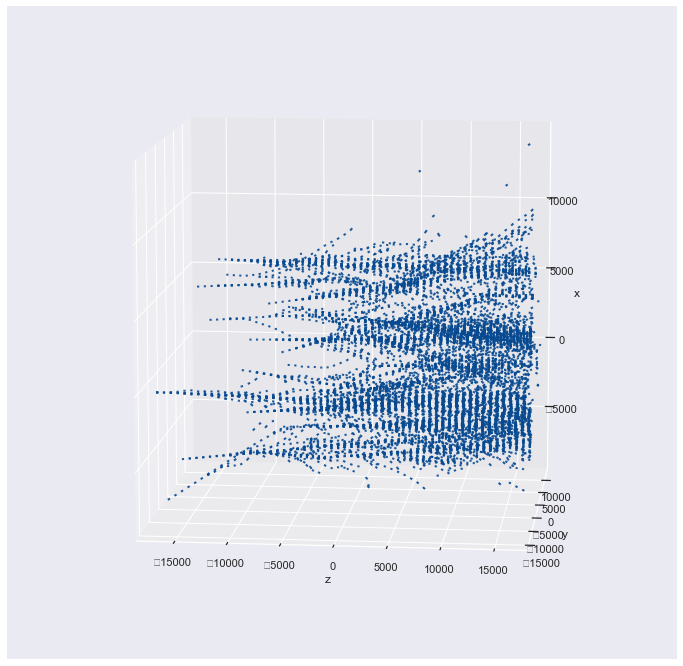

In [128]:
plot_graphx(graphx)

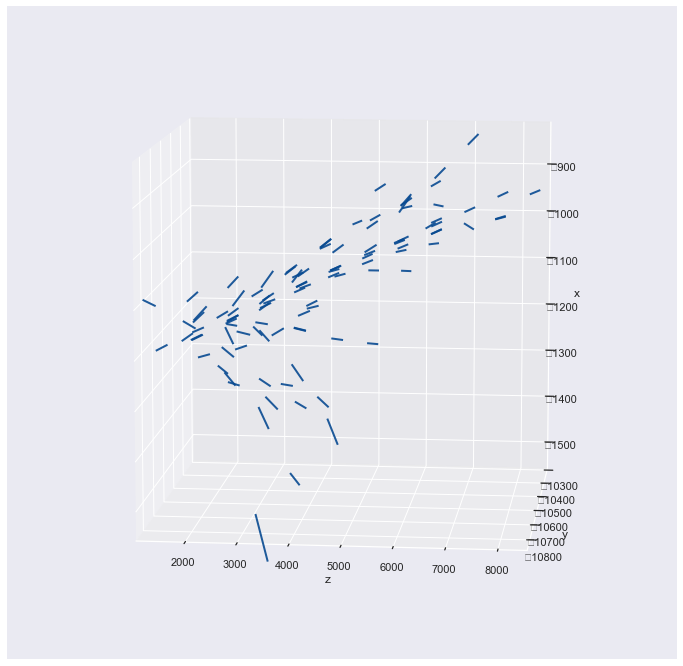

In [129]:
plot_graphx(graphx.subgraph(clusters[4].nodes))